In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Flatten, Dense, Dropout
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

In [2]:
def load_data(file_path, input_column, target_column):
    data = pd.read_csv(file_path)
    return data[input_column].values, data[target_column].values

In [3]:

def preprocess_data(input_data, target_data, sequence_length):
    scaler = MinMaxScaler()
    input_data = scaler.fit_transform(input_data.reshape(-1, 1))
    target_data = scaler.fit_transform(target_data.reshape(-1, 1))

    X, y = [], []
    for i in range(len(input_data) - sequence_length):
        X.append(input_data[i:i + sequence_length])
        y.append(target_data[i + sequence_length])

    X = np.array(X)
    y = np.array(y)

    return X, y, scaler

In [4]:
def build_model(sequence_length):
    model = Sequential()

    model.add(Conv1D(128, 5, activation='relu', input_shape=(sequence_length, 1)))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2))

    model.add(LSTM(64))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [5]:

def train_model(model, X_train, y_train, epochs, batch_size):
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    return model

In [6]:
def evaluate_model(model, X_test, y_test, scaler):
    loss = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss}")

    predicted_values = model.predict(X_test)
    actual_values = scaler.inverse_transform(y_test)
    predicted_values = scaler.inverse_transform(predicted_values)

    return actual_values, predicted_values


In [7]:
def visualize_results(actual_values, predicted_values):
    time_series = range(len(actual_values))
    df = pd.DataFrame({'Time': time_series, 'Actual': actual_values.flatten(), 'Predicted': predicted_values.flatten()})

    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Time', y='Actual', data=df[:500], label='Actual', linewidth=2)
    sns.lineplot(x='Time', y='Predicted', data=df[:500], label='Predicted', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Lead v3')
    plt.title('Actual vs. Predicted Lead v3')
    plt.legend()
    plt.show()

In [8]:
def calculate_metrics(actual_values, predicted_values):
    r2 = r2_score(actual_values, predicted_values)
    correlation_coefficient, _ = pearsonr(actual_values.flatten(), predicted_values.flatten())

    regression_model = LinearRegression()
    regression_model.fit(actual_values.reshape(-1, 1), predicted_values)
    regression_coefficient = regression_model.coef_[0]

    print(f"R-squared: {r2:.4f}")
    print(f"Correlation Coefficient: {correlation_coefficient:.4f}")
    print(f"Regression Coefficient: {regression_coefficient[0]:.4f}")

In [9]:
def save_model(model, model_name):
    model.save(model_name)

Epoch 1/200
59/59 [==============================] - 30s 126ms/step - loss: 0.0646
Epoch 2/200
59/59 [==============================] - 6s 108ms/step - loss: 0.0035
Epoch 3/200
59/59 [==============================] - 6s 110ms/step - loss: 0.0011
Epoch 4/200
59/59 [==============================] - 6s 109ms/step - loss: 5.9738e-04
Epoch 5/200
59/59 [==============================] - 6s 110ms/step - loss: 4.3305e-04
Epoch 6/200
59/59 [==============================] - 7s 110ms/step - loss: 2.8079e-04
Epoch 7/200
59/59 [==============================] - 7s 111ms/step - loss: 2.2957e-04
Epoch 8/200
59/59 [==============================] - 7s 112ms/step - loss: 2.3542e-04
Epoch 9/200
59/59 [==============================] - 7s 111ms/step - loss: 1.6961e-04
Epoch 10/200
59/59 [==============================] - 7s 115ms/step - loss: 1.8629e-04
Epoch 11/200
59/59 [==============================] - 7s 115ms/step - loss: 1.4073e-04
Epoch 12/200
59/59 [==============================] - 7s 114ms/

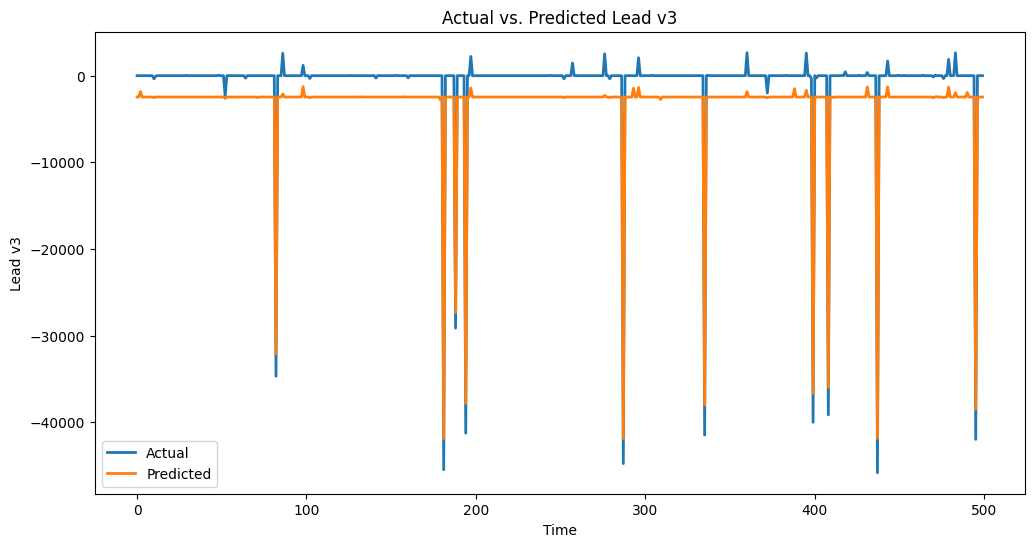

R-squared: 0.7915
Correlation Coefficient: 0.9988
Regression Coefficient: 0.8562


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
if __name__ == '__main__':
    file_path = '/content/preprocessed_s0001_re.csv'
    input_column = 'ii'
    target_column = 'v3'
    sequence_length = 1000

    input_data, target_data = load_data(file_path, input_column, target_column)
    X, y, scaler = preprocess_data(input_data, target_data, sequence_length)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = build_model(sequence_length)
    train_model(model, X_train, y_train, epochs=200, batch_size=512)

    actual_values, predicted_values = evaluate_model(model, X_test, y_test, scaler)
    visualize_results(actual_values, predicted_values)
    calculate_metrics(actual_values, predicted_values)

    save_model(model, 'patient_1_lead_v3.h5')
